# Feature Engineering
Feature Engineering is the key.

  
reference:  
https://www.kaggle.com/mjbahmani/statistical-analysis-for-elo  
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82055  
https://www.kaggle.com/chauhuynh/my-first-kernel-3-699  
https://www.kaggle.com/fabiendaniel/elo-world  
https://www.kaggle.com/raddar/target-true-meaning-revealed  
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82036#479038  
https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/  
https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering this is really helpfull  
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
# import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

print(os.listdir("../data"))

['Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'test.csv', 'merchants.csv', 'historical_transactions.csv', 'train.csv', 'load_data.py', 'sample_submission.csv']


### Load Data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
merchants = pd.read_csv('../data/merchants.csv')
historical_transactions = pd.read_csv('../data/historical_transactions.csv')
new_transactions = pd.read_csv('../data/new_merchant_transactions.csv')
# sample_submission = pd.read_csv('../data/sample_submission.csv')
print('...loaded')

...loaded


### Fill Null Data

In [3]:
# view NA data
print("train set NA data {}".format(train.isna().sum()))
print("test set NA data {}".format(test.isna().sum()))
print("new transaction set NA data {}".format(new_transactions.isna().sum()))
print("historical transaction set NA data {}".format(historical_transactions.isna().sum()))

train set NA data first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
test set NA data first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64
new transaction set NA data authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64
historical transaction set NA data authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
categ

In [4]:
# drop NA data, be careful
train = train.dropna()

# fill the NA data, is it going to have a bad influence on our model?
for df in [historical_transactions, new_transactions]:
    df['category_3'].fillna('A', inplace=True)
    df['category_2'].fillna(1.0, inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

In [22]:
# a helper function to save memory usage, u don't need to understand this one
# @input dataframe
# @return dataframe
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)

### Feature Extraction

Manual feature engineering can be a tedious process (which is why we use automated feature engineering with featuretools!) and often relies on domain expertise. I will concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Basically, our approach is to make as many features as possible and then give them all to the model to use! Later, we can perform feature reduction using the feature importances from the model or other techniques such as PCA.

In [5]:
# print all current features
print(list(train))
print(list(test))
print(list(historical_transactions))
print(list(new_transactions))

['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3', 'target']
['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3']
['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments', 'category_3', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount', 'purchase_date', 'category_2', 'state_id', 'subsector_id']
['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments', 'category_3', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount', 'purchase_date', 'category_2', 'state_id', 'subsector_id']


We need to understand the feature now.
1. the train dataset, we can see that it has card_id, this should be the unique id we can use for user profile, and group or aggregate the data w.r.t this feature. the feature_# in the data_dictionary descibed as Anonymized card categorical feature, we need to understand it later.
2. historical and new transactions. these two dataset have similar data structure.  
    a. 'purchase_date': max','min', require feature extraction.
        - 'month','hour','weekofyear','dayofweek','year', require no further process
        - 'weekend': 'sum', 'mean'
    b. 'merchant_id', 'merchant_category_id', 'subsector_id' need no more process.  
    c. 'purchase_amount': 'sum','max','min','mean','var'.  
    d. 'month_lag': 'max','min','mean','var'  
    e. 'month_diff': 'mean'  
    f. 'authorized_flag': 'sum, 'mean'  
    g. 'category_1': 'sum', 'mean'  
    h. 'category_2': 'mean'  
    i. 'category_3': 'mean'  
    j. 'card_id': 'size'

In [6]:
# helper function, create new column
def create_column(prefix, aggs):
    return [prefix + '_' + key + '_' + agg for key in aggs.keys() for agg in aggs[key]]

In [40]:
datetime.datetime.today()

datetime.datetime(2019, 4, 8, 22, 25, 6, 118662)

In [7]:
## main data preprocessing block

# 1. One important feature here is purchase_date feature, we need to extract it into year, month,
# week of year, day of week, weekend, hour
# 2. get time difference to today which 
# 3. normalize binary data to 1/0 int


for df in [historical_transactions, new_transactions]:
    
    # date conversion
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df['purchase_date'].dt.dayofweek >= 5).astype(int) # 0-5 week day
    df['hour'] = df['purchase_date'].dt.hour
    
    ## time difference
    # https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    
    # normalization
    # TODO still not well done here
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})
    

In [8]:
df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,...,1.0,9,19,2018,10,3,6,1,14,14
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,...,1.0,9,19,2018,12,3,0,0,18,13
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,...,1.0,9,14,2018,17,4,3,0,14,13
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,...,1.0,-1,8,2018,10,3,2,0,9,14
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,...,1.0,-1,29,2018,12,3,3,0,21,13


### Feature aggregation
`groupby`: group a dataframe by a column. In this case we will group by the `card_id`.  
`agg`: perform a calculation on the grouped data such as taking the `mean` of columns. We can either call the function directly (grouped_df.mean()) or use the agg function together with a list of transforms (`grouped_df.agg([mean, max, min, sum])`)  
`merge`: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the `card_id` column.

In [9]:
# create aggregation columns (features)
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['card_id'] = ['size']

aggs['category_1'] = ['sum', 'mean']

for col in ['category_2','category_3']:
    aggs[col+'_mean'] = ['mean'] 

In [10]:
aggs

{'month': ['nunique'],
 'hour': ['nunique'],
 'weekofyear': ['nunique'],
 'dayofweek': ['nunique'],
 'year': ['nunique'],
 'subsector_id': ['nunique'],
 'merchant_id': ['nunique'],
 'merchant_category_id': ['nunique'],
 'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
 'installments': ['sum', 'max', 'min', 'mean', 'var'],
 'purchase_date': ['max', 'min'],
 'month_lag': ['max', 'min', 'mean', 'var'],
 'month_diff': ['mean'],
 'authorized_flag': ['sum', 'mean'],
 'weekend': ['sum', 'mean'],
 'card_id': ['size'],
 'category_1': ['sum', 'mean'],
 'category_2_mean': ['mean'],
 'category_3_mean': ['mean']}

In [11]:
# historical transaction feature engineering
#
# append a column to historical transactions first
for col in ['category_2', 'category_3']:
     historical_transactions[col + '_mean'] = \
        historical_transactions.groupby([col])['purchase_amount'].transform('mean')

# historical transaction features
hist_columns = create_column('hist', aggs)

hist_trans_agg = historical_transactions.groupby('card_id').agg(aggs)
hist_trans_agg.columns = hist_columns
hist_trans_agg.reset_index(drop=False, inplace=False)
hist_trans_agg['hist_purchase_date_diff'] = \
    (hist_trans_agg['hist_purchase_date_max'] - hist_trans_agg['hist_purchase_date_min']).dt.days
hist_trans_agg['hist_purchase_date_average'] = \
    (hist_trans_agg['hist_purchase_date_diff']) / hist_trans_agg['hist_card_id_size']
hist_trans_agg['hist_purchase_date_uptonow'] = \
    (datetime.datetime.today() - hist_trans_agg['hist_purchase_date_max']).dt.days

# merge into train and test dataset
train = train.merge(hist_trans_agg, on='card_id', how='left')
test = test.merge(hist_trans_agg, on='card_id', how='left')

# gc collection, save memory
del hist_trans_agg;gc.collect()

162

In [12]:
# new transaction feature engineering
#
# append a column to new transactions first
for col in ['category_2', 'category_3']:
     new_transactions[col + '_mean'] = \
        new_transactions.groupby([col])['purchase_amount'].transform('mean')

# new transaction features
new_columns = create_column('new', aggs)

new_trans_agg = new_transactions.groupby('card_id').agg(aggs)
new_trans_agg.columns = new_columns
new_trans_agg.reset_index(drop=False, inplace=False)
new_trans_agg['new_purchase_date_diff'] = \
    (new_trans_agg['new_purchase_date_max'] - new_trans_agg['new_purchase_date_min']).dt.days
new_trans_agg['new_purchase_date_average'] = \
    (new_trans_agg['new_purchase_date_diff']) / new_trans_agg['new_card_id_size']
new_trans_agg['new_purchase_date_uptonow'] = \
    (datetime.datetime.today() - new_trans_agg['new_purchase_date_max']).dt.days

# merge into train and test dataset
train = train.merge(new_trans_agg, on='card_id', how='left')
test = test.merge(new_trans_agg, on='card_id', how='left')

# gc collection
del new_trans_agg;gc.collect()

162

In [13]:
# gc collection
del historical_transactions;gc.collect()
del new_transactions;gc.collect()

0

In [14]:
# outliers
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [15]:
# train, test dataset feature engineering
for df in [train, test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_purchase_date_max',\
                     'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['hist_card_id_size'] + df['new_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

In [16]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,23,35,7,...,344.0,0,3,22,6,676,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,24,50,7,...,374.0,0,6,52,1,827,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,14,22,7,...,345.0,0,0,31,8,980,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,16,20,7,...,355.0,0,4,35,9,584,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159749,4,22,17,7,...,345.0,0,2,44,11,523,11,121.0,169.0,-68.613893


We can do the modeling now!

## Evaluation

In [33]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import neighbors

import gc
import matplotlib.pyplot as plt


In [19]:

train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']
del train['target']

In [20]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,...,new_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,9,23,35,7,2,...,344.0,0,3,22,6,676,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,12,24,50,7,2,...,374.0,0,6,52,1,827,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,10,14,22,7,2,...,345.0,0,0,31,8,980,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,6,16,20,7,2,...,355.0,0,4,35,9,584,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,4,22,17,7,2,...,345.0,0,2,44,11,523,11,121.0,169.0,-68.613893


### Let's try some models

In [26]:
print(target.values)

[-0.8202826   0.39291325  0.68805599 ...  0.09349415 -4.67658938
 -1.85941301]


In [24]:
def lightgbm(train, test, n_folds=5):
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    np.sqrt(mean_squared_error(oof, target))
    return feature_importance_df

In [25]:
feature_importance = lightgbm(train, test, n_folds=5)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66653	valid_1's rmse: 3.72219
[200]	training's rmse: 3.59024	valid_1's rmse: 3.68935
[300]	training's rmse: 3.54449	valid_1's rmse: 3.67545
[400]	training's rmse: 3.50848	valid_1's rmse: 3.66793
[500]	training's rmse: 3.47896	valid_1's rmse: 3.66286
[600]	training's rmse: 3.45344	valid_1's rmse: 3.65939
[700]	training's rmse: 3.43056	valid_1's rmse: 3.6571
[800]	training's rmse: 3.4101	valid_1's rmse: 3.65572
[900]	training's rmse: 3.3908	valid_1's rmse: 3.65429
[1000]	training's rmse: 3.37335	valid_1's rmse: 3.6535
[1100]	training's rmse: 3.35718	valid_1's rmse: 3.65337
[1200]	training's rmse: 3.34176	valid_1's rmse: 3.65317
Early stopping, best iteration is:
[1192]	training's rmse: 3.34285	valid_1's rmse: 3.65305
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66842	valid_1's rmse: 3.71357
[200]	training's rmse: 3.59191	valid_1's rmse: 3.68242


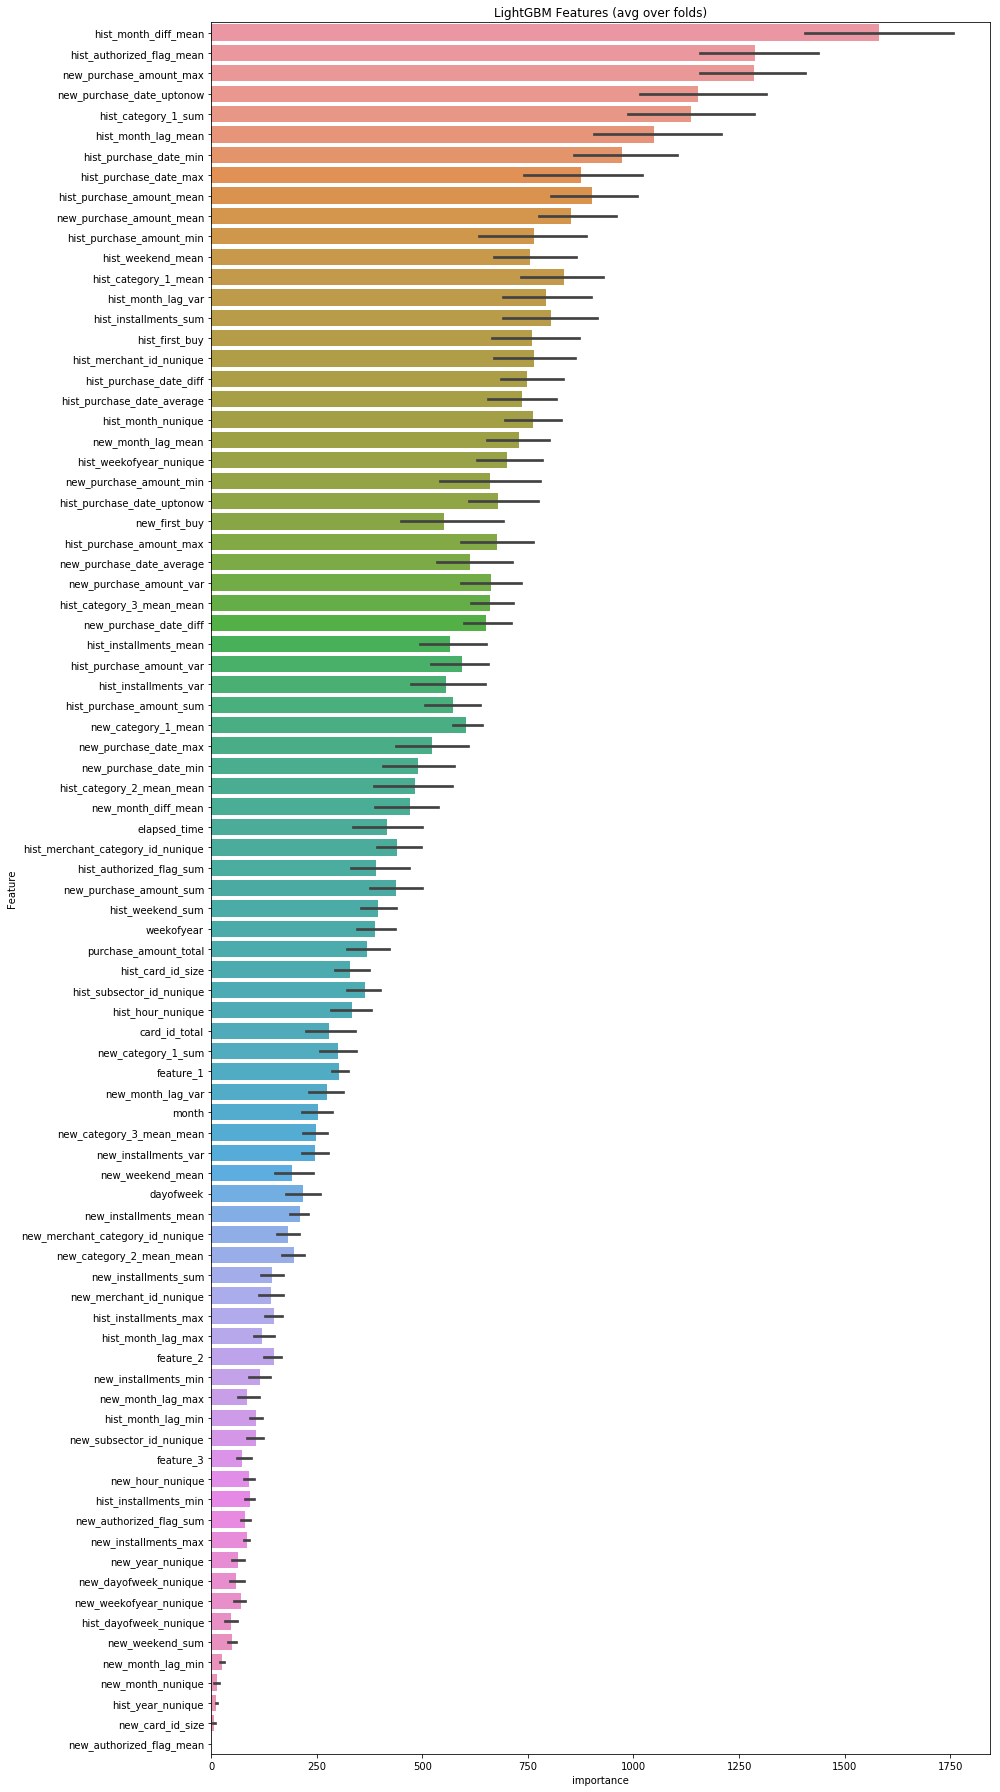

In [26]:
# plot the features
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')
